In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('chained_assignment',None)

In [3]:
fradu_data = pd.read_csv('Fraud_Data.csv')
address_data = pd.read_csv('IpAddress_to_Country.csv')

In [89]:
def country_mapping(ip_address):
    
    df = address_data[(address_data.lower_bound_ip_address<=ip_address)&(address_data.upper_bound_ip_address>=ip_address)]
    if len(df) > 0:
        return df['country'].iloc[0]
    else:
        return 'Unknown'

In [91]:
fradu_data['country'] = fradu_data['ip_address'].apply(country_mapping)

In [163]:
fradu_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,pur_sfter_signup_seconds,pur_sfter_signup_hours,pur_sfter_signup_minutes,device_count,ip_address_count,pur_after_signup,pur_after_signup_days,pur_after_signup_seconds,pur_after_signup_hours,pur_after_signup_minutes
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,13882,3.856111,231.366667,1,1,52 days 03:51:22,52,13882,3.856111,231.366667
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,17944,4.984444,299.066667,1,1,0 days 04:59:04,0,17944,4.984444,299.066667
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1,0.000278,0.016667,12,12,0 days 00:00:01,0,1,0.000278,0.016667
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,60085,16.690278,1001.416667,1,1,5 days 16:41:25,5,60085,16.690278,1001.416667
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,41461,11.516944,691.016667,1,1,50 days 11:31:01,50,41461,11.516944,691.016667


# Question 1

**Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.**

**Before building the predictive model, it is necessary to transform or create features based on the existing ones to better represent the dataset and hence, better training results.**

In [193]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier, cv, DMatrix
xgb.set_config(verbosity=0)

In [101]:
fradu_data['signup_time'] = pd.to_datetime(fradu_data['signup_time'])
fradu_data['purchase_time'] = pd.to_datetime(fradu_data['purchase_time'])

In [156]:
fradu_data['pur_after_signup'] = fradu_data['purchase_time'] - fradu_data['signup_time']
fradu_data['pur_after_signup_days'] = fradu_data['pur_after_signup'].apply(lambda x: x.days)
fradu_data['pur_after_signup_seconds'] = fradu_data['pur_after_signup'].apply(lambda x: x.seconds)
fradu_data['pur_after_signup_hours'] = fradu_data['pur_after_signup_seconds']/3600
fradu_data['pur_after_signup_minutes'] = fradu_data['pur_after_signup_seconds']/60

In [143]:
#Create numeric features from the categorical ones
device_count = fradu_data.groupby(['device_id']).agg({'user_id': 'count'}).reset_index().set_index('device_id')['user_id'].to_dict()
fradu_data['device_count'] = fradu_data['device_id'].map(device_count)

ip_address_count = fradu_data.groupby(['ip_address']).agg({'user_id': 'count'}).reset_index().set_index('ip_address')['user_id'].to_dict()
fradu_data['ip_address_count'] = fradu_data['ip_address'].map(ip_address_count)

In [431]:
le1 = LabelEncoder()
fradu_data['source'] = le1.fit_transform(fradu_data['source'])
le2 = LabelEncoder()
fradu_data['browser'] = le2.fit_transform(fradu_data['browser'])
le3 = LabelEncoder()
fradu_data['sex'] = le3.fit_transform(fradu_data['sex'])
le4 = LabelEncoder()
fradu_data['country'] = le4.fit_transform(fradu_data['country'])

In [421]:
X = fradu_data[['purchase_value','source','browser','sex','age','country','pur_after_signup_days',
                'pur_after_signup_seconds','pur_after_signup_hours','pur_after_signup_minutes','device_count','ip_address_count']]
y = fradu_data['class']

In [422]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [423]:
clf_xgb = XGBClassifier(objective='binary:logistic', learning_rate=0.1)
clf_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True, eval_metric='auc', early_stopping_rounds=20)

[0]	validation_0-auc:0.84351	validation_1-auc:0.84625
[1]	validation_0-auc:0.84352	validation_1-auc:0.84623
[2]	validation_0-auc:0.84354	validation_1-auc:0.84623
[3]	validation_0-auc:0.84359	validation_1-auc:0.84621


C:\Users\EDZ\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-auc:0.84363	validation_1-auc:0.84621
[5]	validation_0-auc:0.84366	validation_1-auc:0.84616
[6]	validation_0-auc:0.84389	validation_1-auc:0.84602
[7]	validation_0-auc:0.84704	validation_1-auc:0.84485
[8]	validation_0-auc:0.84711	validation_1-auc:0.84482
[9]	validation_0-auc:0.84719	validation_1-auc:0.84485
[10]	validation_0-auc:0.85085	validation_1-auc:0.84363
[11]	validation_0-auc:0.85124	validation_1-auc:0.84356
[12]	validation_0-auc:0.85136	validation_1-auc:0.84359
[13]	validation_0-auc:0.85359	validation_1-auc:0.84282
[14]	validation_0-auc:0.85405	validation_1-auc:0.84349
[15]	validation_0-auc:0.85413	validation_1-auc:0.84403
[16]	validation_0-auc:0.85436	validation_1-auc:0.84361
[17]	validation_0-auc:0.85629	validation_1-auc:0.84262
[18]	validation_0-auc:0.85648	validation_1-auc:0.84232
[19]	validation_0-auc:0.85592	validation_1-auc:0.84290
[20]	validation_0-auc:0.85681	validation_1-auc:0.84279


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

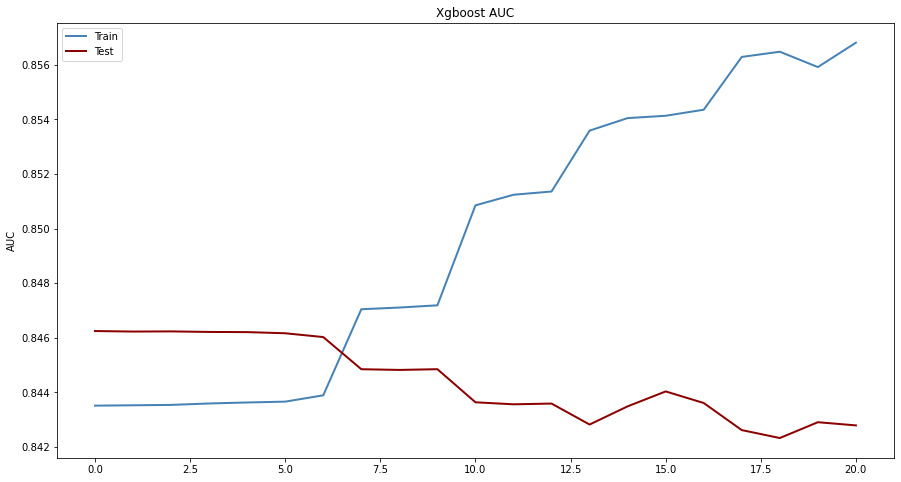

In [424]:
evaluation_result = clf_xgb.evals_result_
x_axis = range(len(evaluation_result['validation_0']['auc']))

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(x_axis, evaluation_result['validation_0']['auc'], label='Train', color='steelblue', linewidth=2)
plt.plot(x_axis, evaluation_result['validation_1']['auc'], label='Test', color='darkred', linewidth=2)

plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

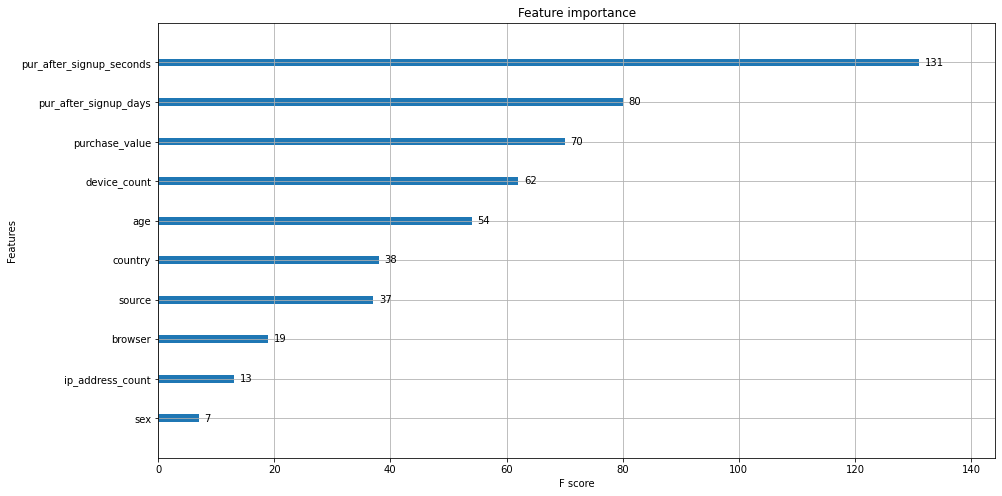

In [425]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(15, 8))
plot_importance(clf_xgb, ax=ax);

In [426]:
from sklearn.metrics import classification_report
y_pred = clf_xgb.predict_proba(X_test)[:, 1]
fpr,tpr,thresholds = roc_curve(y_test, y_pred)

C:\Users\EDZ\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [427]:
print(classification_report(y_test, (y_pred>0.5)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27290
           1       1.00      0.54      0.70      2933

    accuracy                           0.96     30223
   macro avg       0.98      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223



In [428]:
threshold = []
recall = []
precision = []
f1_score = []
for t in np.arange(0, 1, 0.1):
    report = classification_report(y_test, (y_pred > t), output_dict=True, zero_division=1)
    r = report['1']['recall']
    p = report['1']['precision']
    f = report['1']['f1-score']
    threshold.append(t)
    recall.append(r)
    precision.append(p)
    f1_score.append(f)
    
report_df = pd.DataFrame(data={'threshold': threshold, 'recall': recall, 'precision':precision, 'f1_score':f1_score})

In [429]:
report_df

,threshold,recall,precision,f1_score
0,0.0,1.000000,0.097045,0.176921
1,0.1,1.000000,0.097045,0.176921
2,0.2,1.000000,0.097045,0.176921
3,0.3,1.000000,0.097045,0.176921
4,0.4,1.000000,0.097045,0.176921
5,0.5,0.542107,0.999371,0.702918
6,0.6,0.000000,1.000000,0.000000
7,0.7,0.000000,1.000000,0.000000
8,0.8,0.000000,1.000000,0.000000
9,0.9,0.000000,1.000000,0.000000


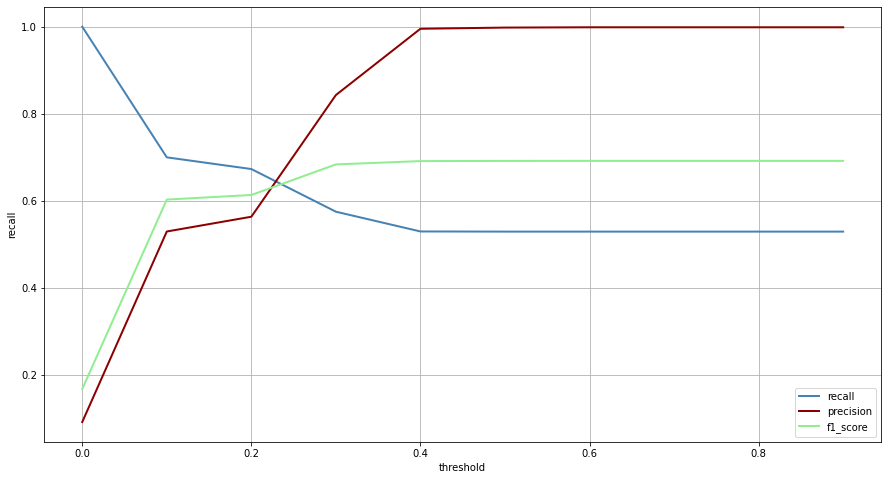

In [388]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=report_df, x='threshold', y='recall', color='steelblue', linewidth=2, label='recall', ax=ax)
sns.lineplot(data=report_df, x='threshold', y='precision', color='darkred', linewidth=2, label='precision', ax=ax)
sns.lineplot(data=report_df, x='threshold', y='f1_score', color='lightgreen', linewidth=2, label='f1_score',ax=ax)
ax.grid(True);

**If the goal is to minimize false positive or to maximize precision as much as possible, this would happen be at the expense of increase in false negative, since the rule would be more conservative to label a prediction as positive, hence more negatives would be generated. This holds true the other way around, if the aim is to decrease false negative, which is more likely in this case because the cost of false negative probably much higher than false positive, this would bring down the precision rate since the algorithm seeks the positive cases more aggresively even it might not be true.**

**To answer the questions, if the cost of false positive is high, the impact is that the model would avoid it by turning down possible positives, which results in a high precision and low recall rate. If the cost of false negative is high, the model would do the exact opposite, which results in high recall and low precision.**

# Question 2
- **What kinds of users are more likely to be classified as at risk? What are their characteristics? Answer and explain these questions in the way that people have no data science background can also understand.**

**Machine learning models such as XGBoost could be too complex and less intuitive to interprete, however, a decision tree model, which runs by logic could be in place to remedy this issue. Previously, we found that there were only a few features that had great impact on the XGBoost model, to give a simplified and intuitive model we can build a decision tree model with the important features above.**

In [393]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from graphviz import Source
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files/Graphviz/bin/'

In [416]:
features = ['pur_after_signup_seconds','pur_after_signup_days','purchase_value','age','country']

In [418]:
clf_dt = DecisionTreeClassifier(max_depth=3)
clf_dt.fit(X_train[features], y_train)

DecisionTreeClassifier(max_depth=3)

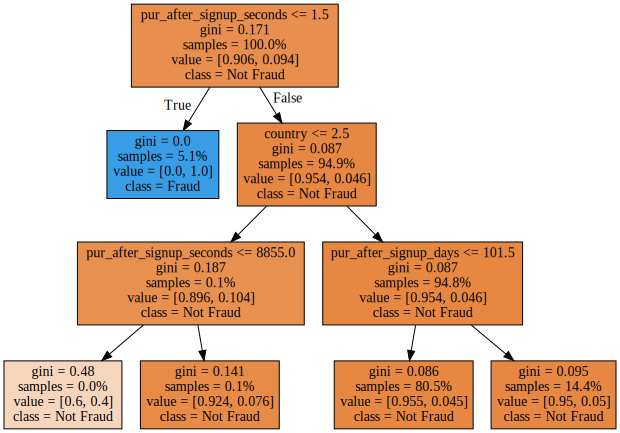

In [420]:
Source(tree.export_graphviz(clf_dt, feature_names=features, filled=True, class_names=['Not Fraud','Fraud'], proportion=True))

In [437]:
le4.inverse_transform([0, 1, 2])

array(['Afghanistan', 'Albania', 'Algeria'], dtype=object)

**According to the model, for users that placed orders right after signup, they are extremely likely of fraud. If users are from country 0,1,2, which are Afghanistan, Albania and Algeria and purchase within 2.5 hours (8855 seconds), the chances of being fraud would be much higher.**

# Question 3
- If this model go live, based on the model opuput, what kind of user experience you would expect?

**Based on the cut-off probability, if a transaction is classfied as fraud consider the live data generated, intervention  is expected to prevent the fraud from happening. If not, the user should have the normal experience.**